In [46]:
import os
import shutil
import zipfile
import requests
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import numpy as np

In [ ]:
# Dataset for 3D Medical Images

import os
import requests
import tarfile

DATA_DIR      = './data/msd_heart'
HEART_TAR_URL = 'https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar'

os.makedirs(DATA_DIR, exist_ok=True)

def download_and_untar(url, out_dir):
    fname = os.path.basename(url)
    fpath = os.path.join(out_dir, fname)
    done  = fpath + '.ok'

    if os.path.exists(done):
        print(f"→ {fname} already extracted, skipping")
        return

    # 1) Download
    print(f"↓ Downloading {fname}…")
    r = requests.get(url, stream=True)
    r.raise_for_status()

    with open(fpath, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1<<20):
            f.write(chunk)

    # 2) Untar
    print(f"↳ Extracting {fname}…")
    with tarfile.open(fpath, 'r') as tar:
        tar.extractall(path=out_dir)

    # 3) Cleanup & mark
    os.remove(fpath)
    open(done, 'w').close()
    print(f"✔ {fname} extracted")

download_and_untar(HEART_TAR_URL, DATA_DIR)


↓ Downloading Task02_Heart.tar…
↳ Extracting Task02_Heart.tar…


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_21716\678451397.py:31: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=out_dir)


✔ Task02_Heart.tar extracted


In [66]:
import os
import glob
import numpy as np
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset

def preprocess_volume(img_path, out_shape=(128,128,128), target_spacing=(1.0,1.0,1.0)):
    """Read, resample to isotropic spacing, crop/pad, normalize, and return a numpy array."""
    img = sitk.ReadImage(img_path)
    orig_spc = img.GetSpacing()
    orig_sz  = img.GetSize()
    new_sz = [
        int(round(orig_sz[i] * (orig_spc[i] / target_spacing[i])))
        for i in range(3)
    ]
    resampled = sitk.Resample(
        img, new_sz, sitk.Transform(), sitk.sitkLinear,
        img.GetOrigin(), target_spacing, img.GetDirection(), 0,
        img.GetPixelID()
    )
    arr = sitk.GetArrayFromImage(resampled)  # (Z,Y,X)
    # Center‐crop
    cz, cy, cx = arr.shape
    tz, ty, tx = out_shape
    sz, sy, sx = max((cz - tz)//2, 0), max((cy - ty)//2, 0), max((cx - tx)//2, 0)
    cropped = arr[sz:sz+tz, sy:sy+ty, sx:sx+tx]
    # Pad if needed
    pad_z = max(0, tz - cropped.shape[0])
    pad_y = max(0, ty - cropped.shape[1])
    pad_x = max(0, tx - cropped.shape[2])
    if any((pad_z, pad_y, pad_x)):
        cropped = np.pad(
            cropped,
            ((0, pad_z), (0, pad_y), (0, pad_x)),
            mode='constant', constant_values=0
        )
    return cropped.astype(np.float32)

class HeartDataset(Dataset):
    def __init__(self, ct_dir, mri_dir,
                 out_shape=(128,128,128),
                 target_spacing=(1.0,1.0,1.0)):
        def list_valid(path, exts):
            return sorted([
                p for p in glob.glob(os.path.join(path, '*'))
                if p.lower().endswith(exts)
                and not os.path.basename(p).startswith('.')
            ])
        self.ct_paths  = list_valid(ct_dir, ('.nii', '.nii.gz'))
        self.mri_paths = list_valid(mri_dir, ('.nii', '.nii.gz'))
        self.out_shape      = out_shape
        self.target_spacing = target_spacing

    def __len__(self):
        return max(len(self.ct_paths), len(self.mri_paths))

    def _load_volume(self, path):
        vol = preprocess_volume(path, out_shape=self.out_shape, target_spacing=self.target_spacing)
        return np.asarray(vol, dtype=np.float32)

    def __getitem__(self, idx):
        start = idx
        # Try each possible CT/MRI pair once
        for _ in range(len(self.ct_paths)):
            ct_path  = self.ct_paths[idx % len(self.ct_paths)]
            mri_path = self.mri_paths[idx % len(self.mri_paths)]
            try:
                ct_vol  = self._load_volume(ct_path)   # (D,H,W)
                mri_vol = self._load_volume(mri_path)
                # to tensor [C=1, D, H, W]
                ct  = torch.from_numpy(ct_vol).unsqueeze(0)
                mri = torch.from_numpy(mri_vol).unsqueeze(0)
                return ct, mri

            except Exception as e:
                print(f"[Dataset] skipping bad pair:\n"
                      f"    CT:  {os.path.basename(ct_path)}\n"
                      f"    MRI: {os.path.basename(mri_path)}\n"
                      f"  Reason: {e}")
                idx += 1

        # If all attempts failed:
        raise RuntimeError(f"No valid CT/MRI pair found starting at index {start}")


In [65]:
import torch.nn as nn

class ResnetBlock3D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm3d(dim),
            nn.ReLU(True),
            nn.Conv3d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm3d(dim),
        )
    def forward(self, x):
        return x + self.block(x)


class Generator3D(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, n_blocks=6):
        super().__init__()
        layers = [
            nn.Conv3d(in_ch, 64, kernel_size=7, padding=3),
            nn.InstanceNorm3d(64), nn.ReLU(True),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm3d(128), nn.ReLU(True),
            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm3d(256), nn.ReLU(True),
        ]
        for _ in range(n_blocks):
            layers.append(ResnetBlock3D(256))
        layers += [
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm3d(128), nn.ReLU(True),
            nn.ConvTranspose3d(128, 64,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm3d(64), nn.ReLU(True),
            nn.Conv3d(64, out_ch, kernel_size=7, padding=3),
            nn.Tanh(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


from torch.nn.utils import spectral_norm

class Discriminator3D(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        layers = []
        chs = [in_ch,64,128,256,512]
        for i in range(len(chs)-1):
            conv = nn.Conv3d(chs[i], chs[i+1], kernel_size=4,
                             stride=(1 if i==0 else 2), padding=1)
            layers.append(spectral_norm(conv))           # <= add spectral norm
            if i>0: layers.append(nn.InstanceNorm3d(chs[i+1]))
            layers.append(nn.LeakyReLU(0.2, True))
        final_conv = nn.Conv3d(512,1,4,padding=1)
        layers.append(spectral_norm(final_conv))         # <= and here
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [67]:
ct_dir  = './data/msd_heart/Task02_Heart/imagesTr'
mri_dir = 'E:/CycleGan/data/mri_train/cropped'

dataset = HeartDataset(ct_dir, mri_dir, out_shape=(64,64,64))
print("CT files:", len(dataset.ct_paths))
print("MRI files:", len(dataset.mri_paths))

loader  = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
ct, mri = next(iter(loader))
print("Loaded shapes:", ct.shape, mri.shape)

G_CT2MRI = Generator3D().to(device)
G_MRI2CT = Generator3D().to(device)
D_CT     = Discriminator3D().to(device)
D_MRI    = Discriminator3D().to(device)

criterion_GAN = nn.MSELoss()
criterion_L1  = nn.L1Loss()

opt_G = torch.optim.Adam(
    list(G_CT2MRI.parameters()) + list(G_MRI2CT.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)
opt_D = torch.optim.Adam(
    list(D_CT.parameters()) + list(D_MRI.parameters()),
    lr=1e-4,  # half the original 2e-4
    betas=(0.5, 0.999)
)


lambda_cyc = 10.0
lambda_idt = 5.0
num_epochs = 20
scaler = GradScaler()

CT files: 20
MRI files: 180
Loaded shapes: torch.Size([1, 1, 64, 64, 64]) torch.Size([1, 1, 64, 64, 64])


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_7076\2995886660.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [68]:
class HeartDataset(Dataset):
    def __init__(self, ct_dir, mri_dir):
        self.ct_files = sorted([...])
        self.mri_files = sorted([...])

    def __getitem__(self, idx):
        ct_path = os.path.join(...); mri_path = os.path.join(...)
        ct = preprocess_volume(ct_path)  # → [1, D, H, W]
        mri = preprocess_volume(mri_path)
        return ct, mri


In [69]:
# ——— Before you start training ———
criterion_GAN = nn.MSELoss()
criterion_L1  = nn.L1Loss()      # <— make sure this is here

lambda_cyc = 10.0
lambda_idt =  5.0

opt_G = torch.optim.Adam(
    list(G_CT2MRI.parameters()) + list(G_MRI2CT.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)
opt_D = torch.optim.Adam(
    list(D_MRI.parameters()) + list(D_CT.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)


In [71]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Lists to record average losses per epoch
train_losses_G = []
train_losses_D = []

for epoch in range(1, num_epochs+1):
    running_G = running_D = count = 0

    for real_CT, real_MRI in loader:
        real_CT, real_MRI = real_CT.to(device), real_MRI.to(device)

        # — Generator step —
        opt_G.zero_grad()
        with autocast():
            idt_MRI = G_CT2MRI(real_MRI)
            idt_CT  = G_MRI2CT(real_CT)
            loss_idt = lambda_idt * (
                criterion_L1(idt_MRI, real_MRI) +
                criterion_L1(idt_CT,   real_CT)
            )

            fake_MRI = G_CT2MRI(real_CT)
            fake_CT  = G_MRI2CT(real_MRI)
            pred_fm  = D_MRI(fake_MRI)
            pred_fc  = D_CT(fake_CT)
            loss_gan = (
                criterion_GAN(pred_fm, torch.ones_like(pred_fm)) +
                criterion_GAN(pred_fc, torch.ones_like(pred_fc))
            )

            rec_CT  = G_MRI2CT(fake_MRI)
            rec_MRI = G_CT2MRI(fake_CT)
            loss_cyc = lambda_cyc * (
                criterion_L1(rec_CT,  real_CT) +
                criterion_L1(rec_MRI, real_MRI)
            )

            loss_G = loss_idt + loss_gan + loss_cyc

        scaler.scale(loss_G).backward()
        scaler.step(opt_G)
        scaler.update()

        # — Discriminator step with label smoothing & grad clip —
        opt_D.zero_grad()
        with autocast():
            real_pred_mri = D_MRI(real_MRI)
            fake_pred_mri = D_MRI(fake_MRI.detach())
            real_pred_ct  = D_CT(real_CT)
            fake_pred_ct  = D_CT(fake_CT.detach())

            sm_real, sm_fake = 0.9, 0.1
            loss_D_mri = 0.5 * (
                criterion_GAN(real_pred_mri, torch.full_like(real_pred_mri, sm_real)) +
                criterion_GAN(fake_pred_mri, torch.full_like(fake_pred_mri, sm_fake))
            )
            loss_D_ct = 0.5 * (
                criterion_GAN(real_pred_ct,  torch.full_like(real_pred_ct,  sm_real)) +
                criterion_GAN(fake_pred_ct,  torch.full_like(fake_pred_ct,  sm_fake))
            )
            loss_D = loss_D_mri + loss_D_ct

        scaler.scale(loss_D).backward()
        torch.nn.utils.clip_grad_norm_(D_MRI.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(D_CT.parameters(),  1.0)
        scaler.step(opt_D)
        scaler.update()

        # Accumulate for averaging
        running_G += loss_G.item()
        running_D += loss_D.item()
        count += 1

    # Compute per-epoch averages
    avg_G = running_G / count
    avg_D = running_D / count
    train_losses_G.append(avg_G)
    train_losses_D.append(avg_D)

    print(f"[Epoch {epoch}/{num_epochs}] "
          f"Avg Loss_G: {avg_G:.4f}  Avg Loss_D: {avg_D:.4f}")

    # Optional checkpointing
    if epoch % 5 == 0:
        torch.save(G_CT2MRI.state_dict(), f'G_CT2MRI_epoch{epoch}.pth')
        torch.save(G_MRI2CT.state_dict(), f'G_MRI2CT_epoch{epoch}.pth')

C:\Users\ADITYA\AppData\Local\Temp\ipykernel_7076\4119423896.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_7076\4119423896.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ADITYA\AppData\Local\Temp\ipykernel_7076\4119423896.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1/20] Avg Loss_G: 17270.9171  Avg Loss_D: 1.6583
[Epoch 2/20] Avg Loss_G: 17268.1463  Avg Loss_D: 0.6030
[Epoch 3/20] Avg Loss_G: 17266.3492  Avg Loss_D: 0.3278
[Epoch 4/20] Avg Loss_G: 17265.5832  Avg Loss_D: 0.4136
[Epoch 5/20] Avg Loss_G: 17264.9512  Avg Loss_D: 0.3005
[Epoch 6/20] Avg Loss_G: 17265.1412  Avg Loss_D: 0.1838
[Epoch 7/20] Avg Loss_G: 17265.7817  Avg Loss_D: 0.1129
[Epoch 8/20] Avg Loss_G: 17264.3685  Avg Loss_D: 0.0378
[Epoch 9/20] Avg Loss_G: 17264.6276  Avg Loss_D: 0.0726
[Epoch 10/20] Avg Loss_G: 17264.3183  Avg Loss_D: 0.0315
[Epoch 11/20] Avg Loss_G: 17264.3937  Avg Loss_D: 0.0195
[Epoch 12/20] Avg Loss_G: 17264.1328  Avg Loss_D: 0.0129
[Epoch 13/20] Avg Loss_G: 17264.4170  Avg Loss_D: 0.0116
[Epoch 14/20] Avg Loss_G: 17263.9225  Avg Loss_D: 0.0065
[Epoch 15/20] Avg Loss_G: 17263.6616  Avg Loss_D: 0.0106
[Epoch 16/20] Avg Loss_G: 17263.4716  Avg Loss_D: 0.0084
[Epoch 17/20] Avg Loss_G: 17263.5148  Avg Loss_D: 0.0067
[Epoch 18/20] Avg Loss_G: 17263.4933  Av

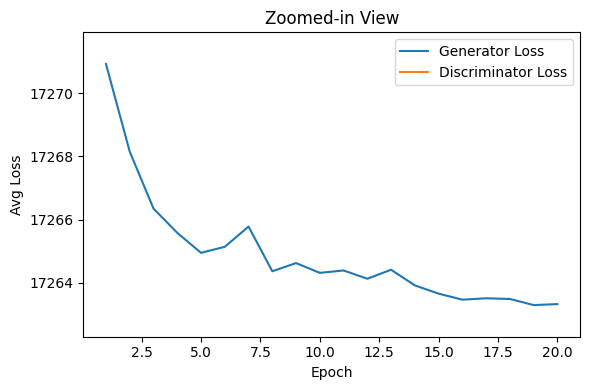

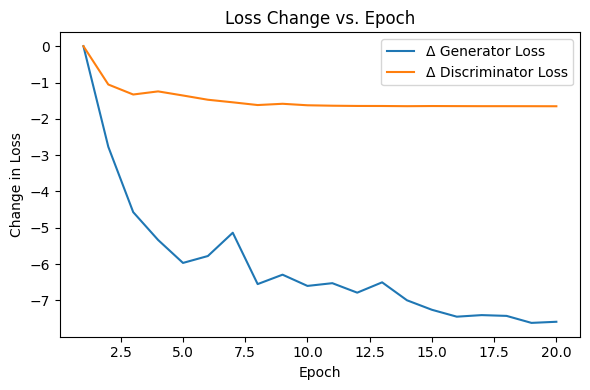

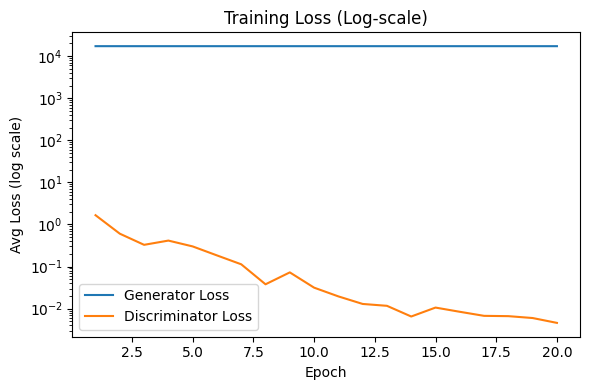

In [91]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs+1))

# 1) Zoomed‑in on G‑loss band
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses_G, label='Generator Loss')
plt.plot(epochs, train_losses_D, label='Discriminator Loss')
plt.xlabel('Epoch'); plt.ylabel('Avg Loss')
plt.title('Zoomed‑in View')
# zoom to ±1 around the G‑loss range
ymin = min(train_losses_G) - 1.0
ymax = max(train_losses_G) + 1.0
plt.ylim(ymin, ymax)
plt.legend(); plt.tight_layout()

# 2) Δ‑loss from epoch 1
g0 = train_losses_G[0]
d0 = train_losses_D[0]
delta_G = [g - g0 for g in train_losses_G]
delta_D = [d - d0 for d in train_losses_D]

plt.figure(figsize=(6,4))
plt.plot(epochs, delta_G, label='Δ Generator Loss')
plt.plot(epochs, delta_D, label='Δ Discriminator Loss')
plt.xlabel('Epoch'); plt.ylabel('Change in Loss')
plt.title('Loss Change vs. Epoch')
plt.legend(); plt.tight_layout()

# 3) Log‑scale view
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses_G, label='Generator Loss')
plt.plot(epochs, train_losses_D, label='Discriminator Loss')
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Avg Loss (log scale)')
plt.title('Training Loss (Log‑scale)')
plt.legend(); plt.tight_layout()

plt.show()


In [77]:
import torch
import SimpleITK as sitk
import numpy as np
from torch import nn

# --- PATHS TO UPDATE ---
ct_path          = 'E:/CycleGan/data/msd_heart/Task02_Heart/imagesTs/la_002.nii.gz'      # your input CT
model_checkpoint = 'G_MRI2CT_epoch25.pth'        # your saved generator checkpoint
out_path         = 'translated_MRI.nii.gz'       # where to write the translated MRI

# --- 1) Preprocess helper ---
def preprocess_volume(img_path, out_shape=(64,64,64), target_spacing=(1.0,1.0,1.0)):
    img = sitk.ReadImage(img_path)
    og_sp, og_sz = img.GetSpacing(), img.GetSize()
    new_sz = [int(round(og_sz[i] * (og_sp[i]/target_spacing[i]))) for i in range(3)]
    resampled = sitk.Resample(
        img, new_sz, sitk.Transform(), sitk.sitkLinear,
        img.GetOrigin(), target_spacing, img.GetDirection(), 0,
        img.GetPixelID()
    )
    arr = sitk.GetArrayFromImage(resampled)  # shape (Z,Y,X)
    cz, cy, cx = arr.shape
    tz, ty, tx = out_shape
    sz, sy, sx = max((cz-tz)//2,0), max((cy-ty)//2,0), max((cx-tx)//2,0)
    cropped = arr[sz:sz+tz, sy:sy+ty, sx:sx+tx]
    pz, py, px = max(0, tz-cropped.shape[0]), max(0, ty-cropped.shape[1]), max(0, tx-cropped.shape[2])
    if any((pz,py,px)):
        cropped = np.pad(cropped, ((0,pz),(0,py),(0,px)), mode='constant')
    return cropped.astype(np.float32)

# --- 2) Generator3D definition matching your saved checkpoint (uses self.model) ---
class ResnetBlock3D(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(ch, ch, 3, padding=1),
            nn.InstanceNorm3d(ch), nn.ReLU(True),
            nn.Conv3d(ch, ch, 3, padding=1),
            nn.InstanceNorm3d(ch),
        )
    def forward(self, x):
        return x + self.block(x)

class Generator3D(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, n_blocks=6):
        super().__init__()
        layers = [
            nn.Conv3d(in_ch, 64, 7, padding=3),
            nn.InstanceNorm3d(64), nn.ReLU(True),
            nn.Conv3d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm3d(128), nn.ReLU(True),
            nn.Conv3d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm3d(256), nn.ReLU(True),
        ]
        for _ in range(n_blocks):
            layers.append(ResnetBlock3D(256))
        layers += [
            nn.ConvTranspose3d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm3d(128), nn.ReLU(True),
            nn.ConvTranspose3d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm3d(64), nn.ReLU(True),
            nn.Conv3d(64, out_ch, 7, padding=3),
            nn.Tanh(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- 3) Load model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator3D().to(device)
state = torch.load(model_checkpoint, map_location=device)
G.load_state_dict(state)
G.eval()

# --- 4) Read and preprocess CT ---
ct_ni = sitk.ReadImage(ct_path)
ct_arr = preprocess_volume(ct_path, out_shape=(64,64,64))
ct_tensor = torch.from_numpy(ct_arr).unsqueeze(0).unsqueeze(0).to(device)  # shape [1,1,D,H,W]

# --- 5) Forward pass ---
with torch.no_grad():
    fake_mri_tensor = G(ct_tensor)

# --- 6) Convert to NumPy and save as NIfTI ---
fake_mri = fake_mri_tensor.squeeze().cpu().numpy()
out_ni = sitk.GetImageFromArray(fake_mri)
out_ni.SetOrigin(ct_ni.GetOrigin())
out_ni.SetSpacing(ct_ni.GetSpacing())
out_ni.SetDirection(ct_ni.GetDirection())
sitk.WriteImage(out_ni, out_path)

print(f"Translated MRI saved to: {out_path}")


Translated MRI saved to: translated_MRI.nii.gz


In [87]:
import numpy as np
import SimpleITK as sitk
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- PATHS TO SET ---
gt_path   = 'E:/CycleGan/data/mri_train/cropped/pat0_cropped.nii.gz'  # ground‑truth MRI
fake_path = 'translated_MRI.nii.gz'                                   # generated MRI

# 1) Load full GT and fake patch as NumPy arrays
gt_img   = sitk.ReadImage(gt_path)
fake_img = sitk.ReadImage(fake_path)

gt_full = sitk.GetArrayFromImage(gt_img).astype(np.float32)   # shape (Z, Y, X)
fake    = sitk.GetArrayFromImage(fake_img).astype(np.float32) # shape (64, 64, 64)

# 2) Center‑crop GT to match fake’s shape
fz, fy, fx = fake.shape
gz, gy, gx = gt_full.shape

sz = (gz - fz) // 2
sy = (gy - fy) // 2
sx = (gx - fx) // 2

gt_crop = gt_full[sz:sz+fz, sy:sy+fy, sx:sx+fx]

# 3) Normalize to [0,1] using GT’s full range
gt_min, gt_max = gt_full.min(), gt_full.max()
if gt_max - gt_min < 1e-6:
    raise ValueError("Ground truth volume is nearly constant; cannot normalize")

gt_norm   = (gt_crop - gt_min) / (gt_max - gt_min)
fake_norm = (fake    - gt_min) / (gt_max - gt_min)

# 4) Compute metrics on the matching 64³ block
data_range = 1.0  # since both are in [0,1]

ssim_val = ssim(gt_norm, fake_norm, data_range=data_range)
psnr_val = psnr(gt_norm, fake_norm, data_range=data_range)
mae_val  = np.mean(np.abs(gt_norm - fake_norm))

# 5) Print results
print(f"GT crop shape:   {gt_norm.shape}")
print(f"Fake shape:      {fake_norm.shape}")
print(f"SSIM:            {ssim_val:.4f}")
print(f"PSNR:            {psnr_val:.2f} dB")
print(f"MAE:             {mae_val:.4f}")


GT crop shape:   (64, 64, 64)
Fake shape:      (64, 64, 64)
SSIM:            0.0005
PSNR:            9.74 dB
MAE:             0.3118


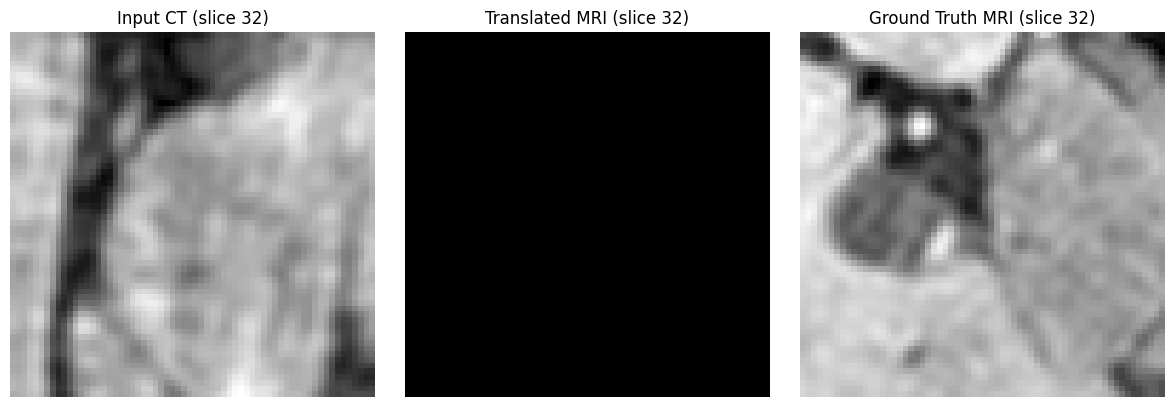

In [90]:
import matplotlib.pyplot as plt

# pick the middle slice along Z
slice_idx = ct_arr.shape[0] // 2  # also = fake_mri.shape[0] = gt_crop.shape[0]

plt.figure(figsize=(12,4))

# Input CT
plt.subplot(1,3,1)
plt.imshow(ct_arr[slice_idx], cmap='gray')
plt.title('Input CT (slice {})'.format(slice_idx))
plt.axis('off')

# Translated MRI
plt.subplot(1,3,2)
plt.imshow(fake_mri[slice_idx], cmap='gray')
plt.title('Translated MRI (slice {})'.format(slice_idx))
plt.axis('off')

# Ground‑Truth MRI (cropped)
plt.subplot(1,3,3)
plt.imshow(gt_crop[slice_idx], cmap='gray')
plt.title('Ground Truth MRI (slice {})'.format(slice_idx))
plt.axis('off')

plt.tight_layout()
plt.show()


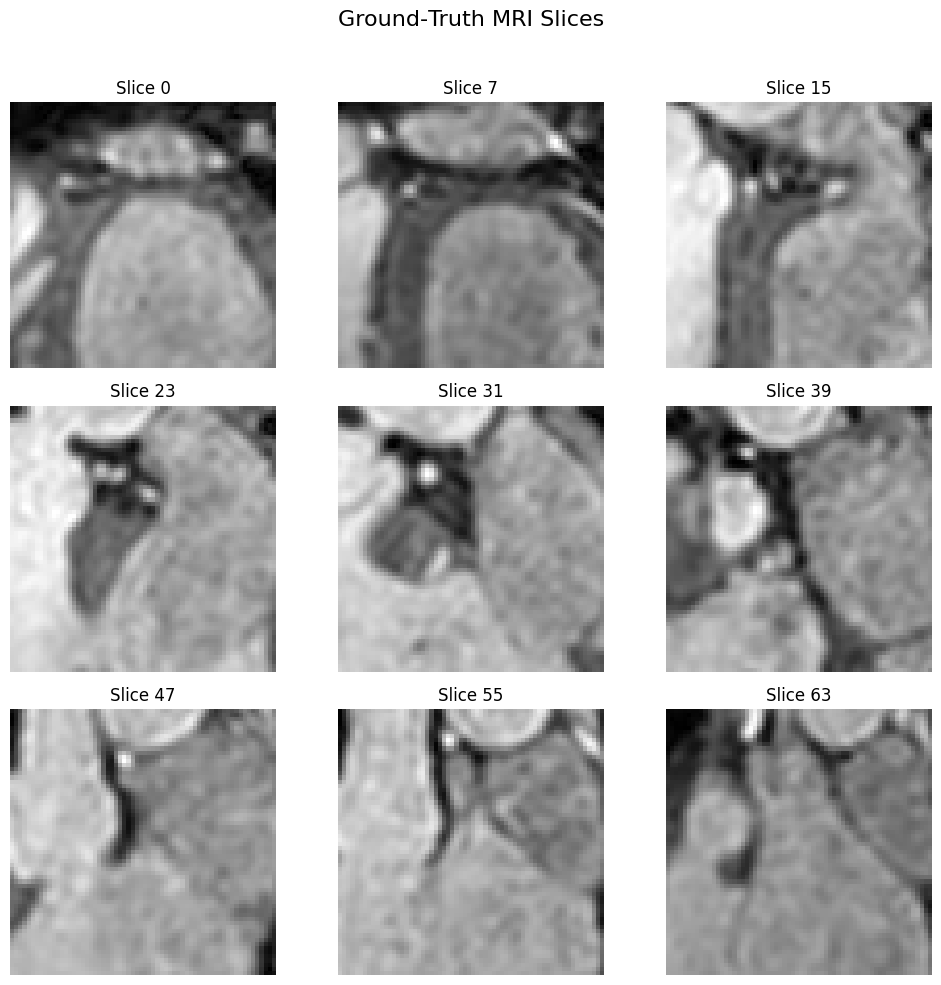

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# assume gt_crop is your 64×64×64 ground‐truth block from before

depth = gt_crop.shape[0]
num_slices = 9   # total slices you want to see
# pick indices evenly spaced through the volume
slice_idxs = np.linspace(0, depth-1, num_slices, dtype=int)

# layout: 3 rows × 3 cols
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    idx = slice_idxs[i]
    ax.imshow(gt_crop[idx], cmap='gray')
    ax.set_title(f"Slice {idx}")
    ax.axis('off')

fig.suptitle("Ground‑Truth MRI Slices", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


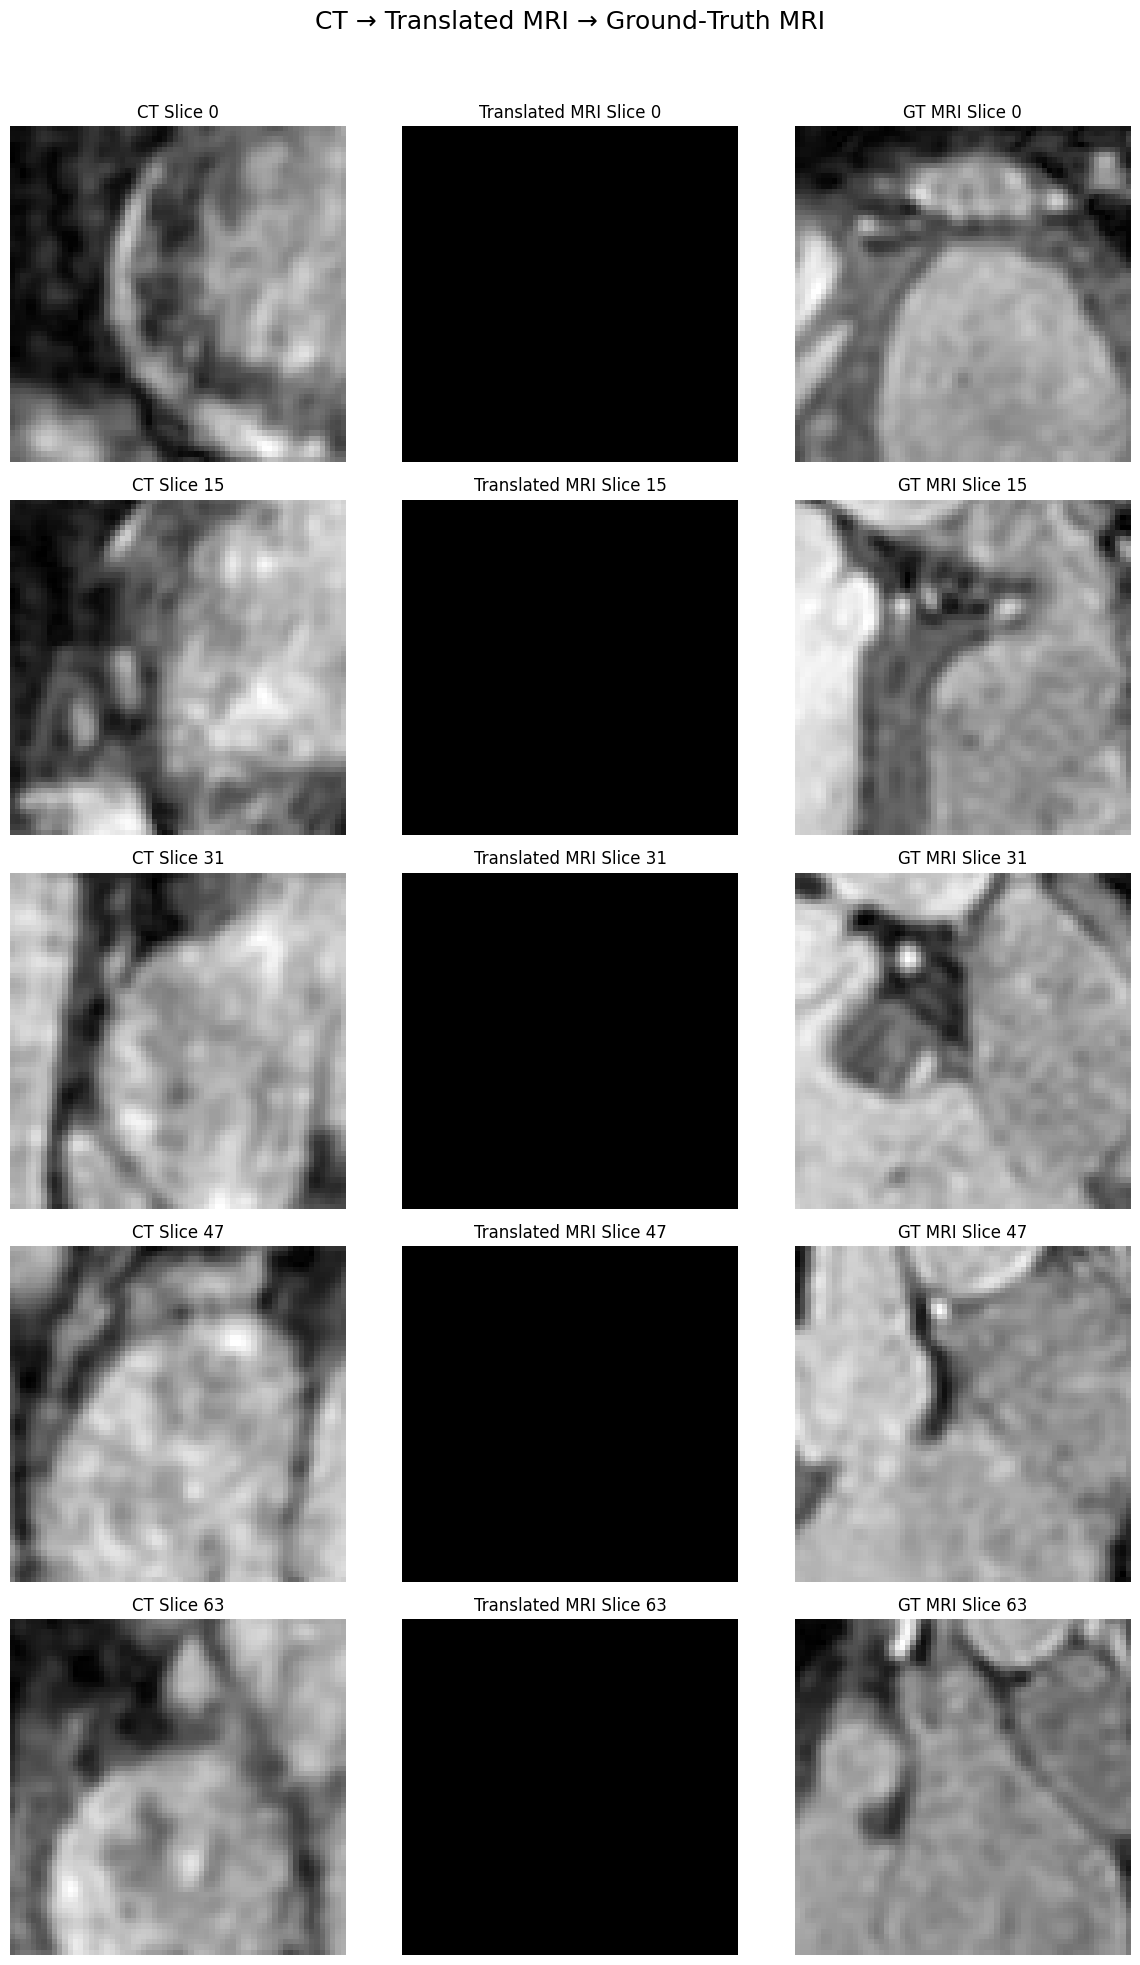

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Number of slices you want to display
num_rows = 5

# Total depth of your volumes
depth = ct_arr.shape[0]

# Pick `num_rows` slice indices evenly spaced through the volume
slice_idxs = np.linspace(0, depth-1, num_rows, dtype=int)

# Create a figure with `num_rows` rows and 3 columns
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i, idx in enumerate(slice_idxs):
    # Input CT
    ax = axes[i, 0]
    ax.imshow(ct_arr[idx], cmap='gray')
    ax.set_title(f'CT Slice {idx}')
    ax.axis('off')

    # Translated MRI
    ax = axes[i, 1]
    ax.imshow(fake_mri[idx], cmap='gray')
    ax.set_title(f'Translated MRI Slice {idx}')
    ax.axis('off')

    # Ground‑Truth MRI
    ax = axes[i, 2]
    ax.imshow(gt_crop[idx], cmap='gray')
    ax.set_title(f'GT MRI Slice {idx}')
    ax.axis('off')

fig.suptitle("CT → Translated MRI → Ground‑Truth MRI", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
